In [1]:
#tf -> tflite 만들기
import tensorflow as tf
tf.__version__

'2.15.0'

In [2]:
import numpy as np
from tensorflow import keras # keras가 필요한 이유 : Lite로 변환하기 위해
import matplotlib.pyplot as plt
import math

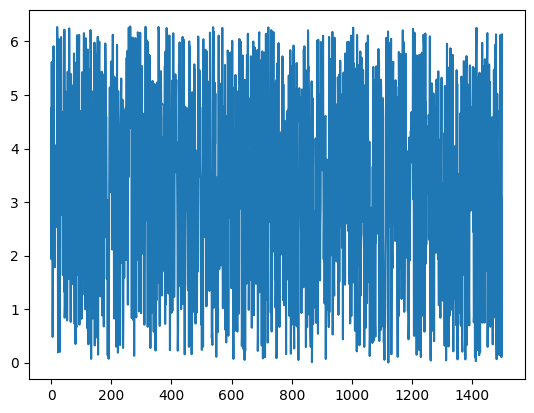

In [3]:
#사인파 생성, random, seed
SAMPLES = 1500

np.random.seed(786) # seed 따라 출력값이 달라짐
tf.random.set_seed(786)

x_value = np.random.uniform(low = 0, high=2*math.pi, size=SAMPLES)
plt.plot(x_value)
plt.show()

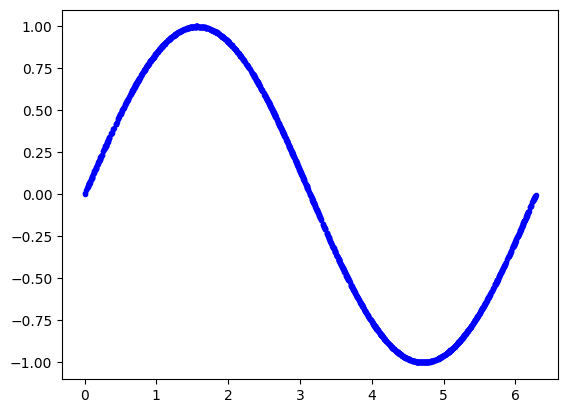

In [4]:
# x_value 통해서 y_value값 샘플링
np.random.shuffle(x_value)
y_value = np.sin(x_value)

plt.plot(x_value, y_value, 'b.')
plt.show()

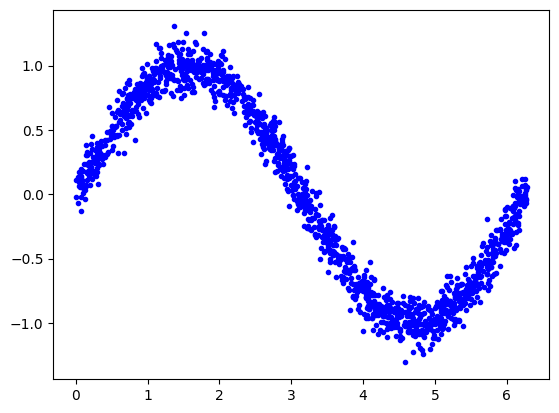

In [5]:
#노이즈
y_value = y_value+0.1*np.random.randn(*y_value.shape)
plt.plot(x_value, y_value, 'b.')
plt.show()

900 300 300
300


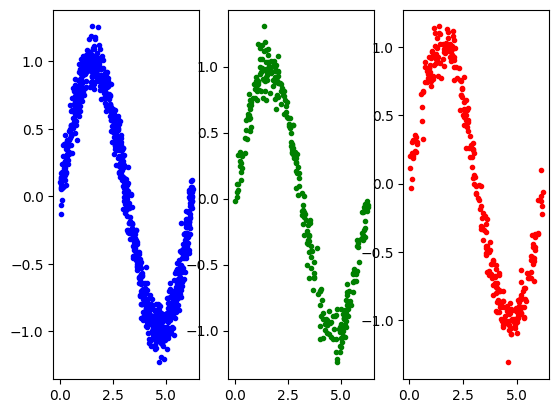

In [6]:
#train 60%
#validation 20%
#test 20%

TRAIN_SPILT = int(0.6*SAMPLES)
TEST_SPILT = int(0.2*SAMPLES)
VALIDATION_SPILT = int(0.2*SAMPLES)

x_train, x_test, x_validation = np.split(x_value, [TRAIN_SPILT, TRAIN_SPILT+TEST_SPILT]) # split 인자는 자르는 위치
print(len(x_train), len(x_test), len(x_validation))

y_train, y_test, y_validation = np.split(y_value, [TRAIN_SPILT, TRAIN_SPILT+TEST_SPILT])

fig = plt.figure()
ax1 = fig.add_subplot(1,3,1)
plt.plot(x_train, y_train, 'b.', label = "Train")
ax2 = fig.add_subplot(1,3,2)
plt.plot(x_validation, y_validation, 'g.', label = "Train")
ax3 = fig.add_subplot(1,3,3)
plt.plot(x_test, y_test, 'r.', label = "Train")

print(len(x_test))


In [7]:
#모델을 생성, 컴파일

model = tf.keras.Sequential()

model.add(keras.layers.Dense(16, activation='relu', input_shape=(1,)))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1)) #x에 대한 y의 값이므로 output_layer는 1개

model.compile(optimizer='adam', loss='mse', metrics=['mae']) # 'mae'는 모델의 성능을 측정하는 지표

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                32        
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 321 (1.25 KB)
Trainable params: 321 (1.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
train_info = model.fit(
    x_train,
    y_train,
    epochs=350,
    batch_size=65,
    validation_data=(x_validation, y_validation)

)

Epoch 1/350


14/14 [==============================] - 1s 15ms/step - loss: 0.4156 - mae: 0.5659 - val_loss: 0.4662 - val_mae: 0.5920
Epoch 2/350
14/14 [==============================] - 0s 4ms/step - loss: 0.3746 - mae: 0.5283 - val_loss: 0.4336 - val_mae: 0.5699
Epoch 3/350
14/14 [==============================] - 0s 4ms/step - loss: 0.3468 - mae: 0.5086 - val_loss: 0.4003 - val_mae: 0.5492
Epoch 4/350
14/14 [==============================] - 0s 4ms/step - loss: 0.3212 - mae: 0.4908 - val_loss: 0.3688 - val_mae: 0.5282
Epoch 5/350
14/14 [==============================] - 0s 4ms/step - loss: 0.2950 - mae: 0.4701 - val_loss: 0.3355 - val_mae: 0.5049
Epoch 6/350
14/14 [==============================] - 0s 4ms/step - loss: 0.2705 - mae: 0.4517 - val_loss: 0.3090 - val_mae: 0.4845
Epoch 7/350
14/14 [==============================] - 0s 4ms/step - loss: 0.2506 - mae: 0.4360 - val_loss: 0.2806 - val_mae: 0.4643
Epoch 8/350
14/14 [==============================] - 0s 4ms/step - loss: 0.2310 

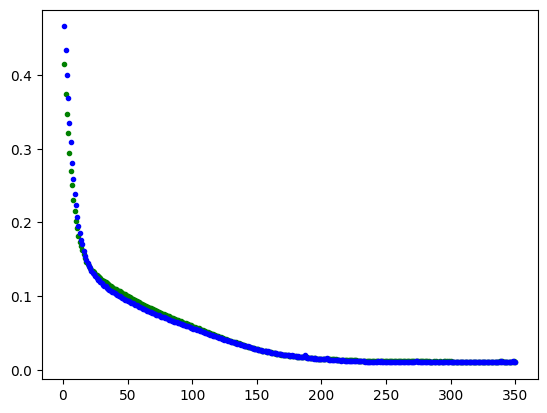

In [9]:
loss=train_info.history['loss']
validation_loss=train_info.history['val_loss']

epochs_list=range(1, 350+1)

plt.plot(epochs_list, loss, 'g.', label='Train loss')
plt.plot(epochs_list, validation_loss, 'b.', label='Validation loss')


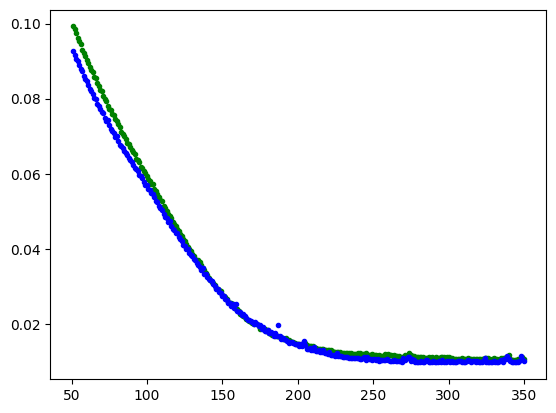

In [10]:
SKIP=50


plt.plot(epochs_list[SKIP:], loss[SKIP:], 'g.', label='Train loss')
plt.plot(epochs_list[SKIP:], validation_loss[SKIP:], 'b.', label='Validation loss')


10/10 [==============================] - 0s 1ms/step


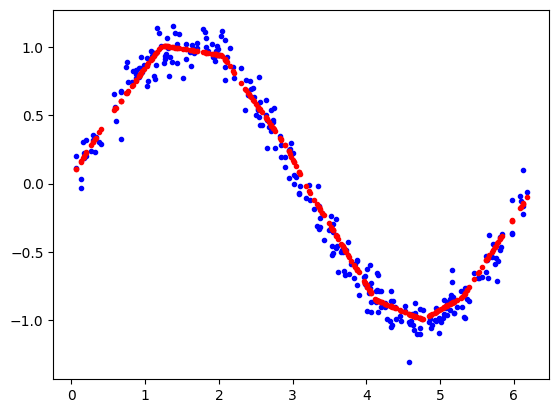

In [11]:
loss = model.evaluate(x_test, y_test)

preditions=model.predict(x_test)

plt.clf()
plt.plot(x_test, y_test, 'b.', label='Actual')
plt.plot(x_test, preditions, 'r.', label='Predicted')
plt.show()

In [12]:
#TFLite 변환
converter=tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations=[tf.lite.Optimize.DEFAULT] #DEFAULT->speed도 적당, memory도 적당
tflite_model=converter.convert()

#.tflite 파일 저장
open("sinwave_mode.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Public\Documents\ESTsoft\CreatorTemp\tmpyy3wxfv0\assets


INFO:tensorflow:Assets written to: C:\Users\Public\Documents\ESTsoft\CreatorTemp\tmpyy3wxfv0\assets


3168

In [13]:
# .c와 .h 파일 만드는 법
from tensorflow.lite.python.util import convert_bytes_to_c_source

source, header = convert_bytes_to_c_source(
    tflite_model,
    "sine_model",
    include_path='sine_model.h'
)

with open('sine_model.h', 'w') as file:
    file.write(header)

with open('sine_model.cpp', 'w') as file:
    file.write(source)